In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Create a simple movie dataset
movies_data = {
    'movie_id': [1, 2, 3, 4, 5],
    'title': ['The Dark Knight', 'Inception', 'The Matrix', 'Jurassic Park', 'Toy Story'],
    'year': [2008, 2010, 1999, 1993, 1995],
    'length_min': [152, 148, 136, 127, 81],
    'action': [0.9, 0.8, 0.95, 0.7, 0.3],
    'scifi': [0.4, 0.9, 0.95, 0.8, 0.1],
    'family': [0.2, 0.2, 0.1, 0.6, 0.9]
}

movies_df = pd.DataFrame(movies_data)
print("Movie Dataset:")
print(movies_df)

Movie Dataset:
   movie_id            title  year  length_min  action  scifi  family
0         1  The Dark Knight  2008         152    0.90   0.40     0.2
1         2        Inception  2010         148    0.80   0.90     0.2
2         3       The Matrix  1999         136    0.95   0.95     0.1
3         4    Jurassic Park  1993         127    0.70   0.80     0.6
4         5        Toy Story  1995          81    0.30   0.10     0.9


In [3]:
# Extract numerical features for distance calculation
numerical_features = ['year', 'length_min', 'action', 'scifi', 'family']
feature_matrix = movies_df[numerical_features].values

# Normalize features to [0,1] range to ensure each contributes equally
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(feature_matrix)

# Create a DataFrame with normalized features for better visualization
normalized_df = pd.DataFrame(
    normalized_features, 
    columns=numerical_features, 
    index=movies_df['title']
)
print("\nNormalized Features:")
print(normalized_df)


Normalized Features:
                     year  length_min    action     scifi  family
title                                                            
The Dark Knight  0.882353    1.000000  0.923077  0.352941   0.125
Inception        1.000000    0.943662  0.769231  0.941176   0.125
The Matrix       0.352941    0.774648  1.000000  1.000000   0.000
Jurassic Park    0.000000    0.647887  0.615385  0.823529   0.625
Toy Story        0.117647    0.000000  0.000000  0.000000   1.000


In [4]:
# Calculate distance matrices using scikit-learn
euclidean_matrix = euclidean_distances(normalized_features)
manhattan_matrix = manhattan_distances(normalized_features)
cosine_sim_matrix = cosine_similarity(normalized_features)
cosine_dist_matrix = 1 - cosine_sim_matrix

# Create DataFrames for better visualization
movie_titles = movies_df['title'].tolist()
euclidean_df = pd.DataFrame(euclidean_matrix, index=movie_titles, columns=movie_titles)
manhattan_df = pd.DataFrame(manhattan_matrix, index=movie_titles, columns=movie_titles)
cosine_df = pd.DataFrame(cosine_dist_matrix, index=movie_titles, columns=movie_titles)

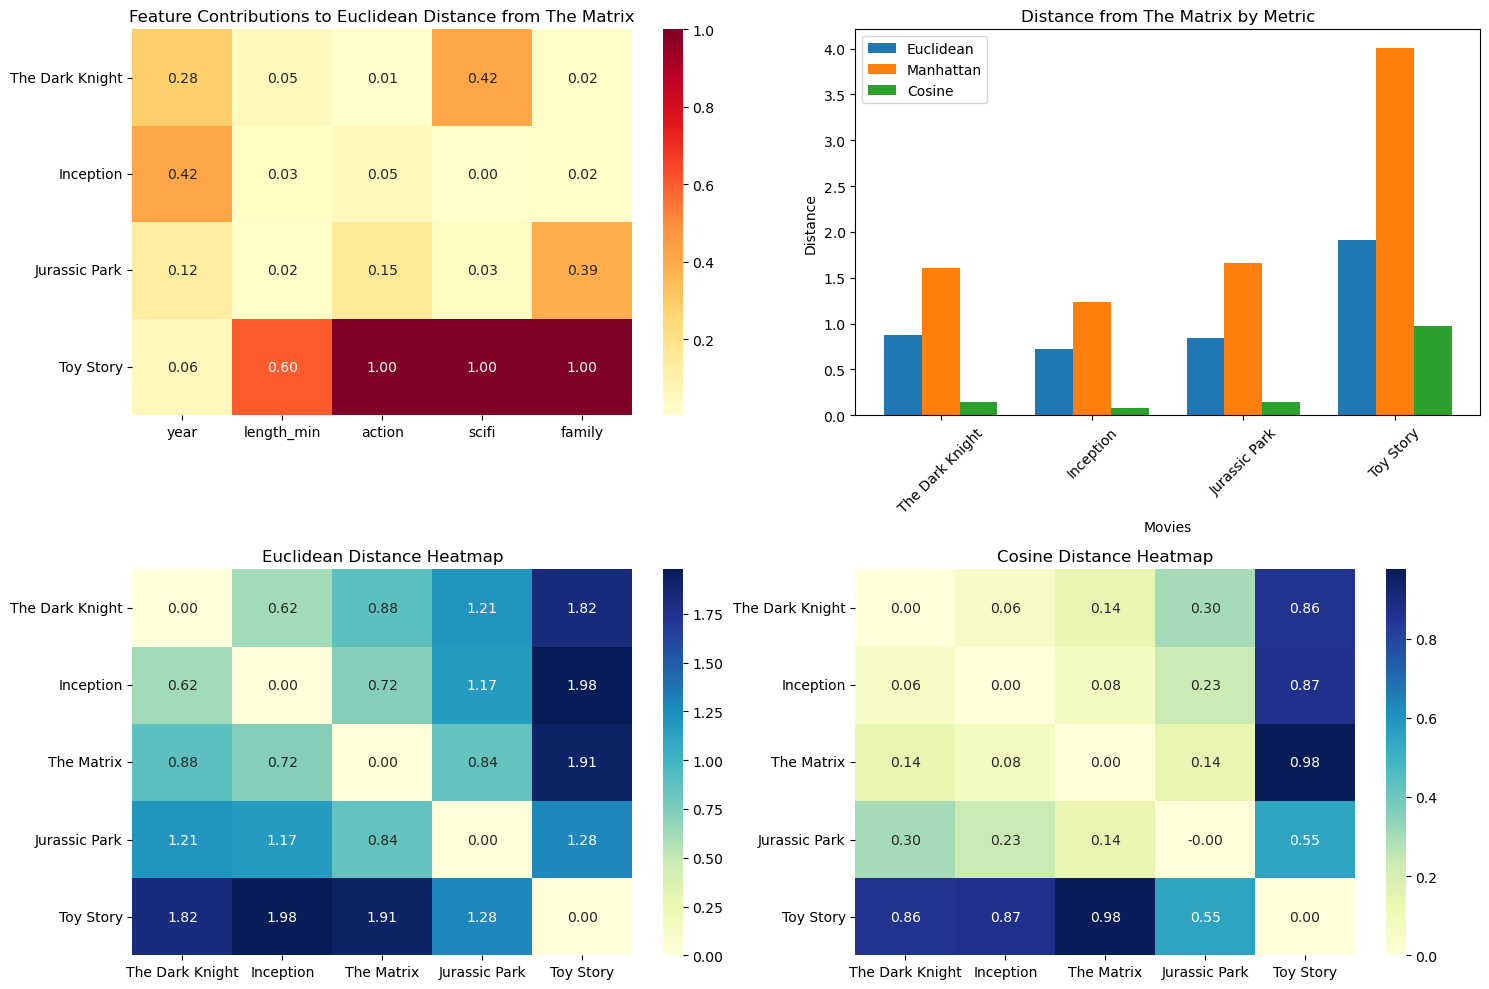


Rank comparison - movies sorted by similarity to The Matrix
                 Euclidean  Manhattan    Cosine
Inception         0.720826   1.230666  0.079691
Jurassic Park     0.842812   1.665788  0.139560
The Dark Knight   0.878230   1.603746  0.140320
Toy Story         1.911921   4.009942  0.975017

Feature importance experiment:
If we change only the 'action' score for Inception, how does each distance metric respond?

Distance between Inception and The Matrix:

Euclidean metric:
  Original: 0.7208
  With less action: 0.8649 (+20.0%)
  With more action: 0.6829 (-5.3%)

Manhattan metric:
  Original: 1.2307
  With less action: 1.5307 (+24.4%)
  With more action: 0.9999 (-18.8%)

Cosine metric:
  Original: 0.0797
  With less action: 0.1293 (+62.3%)
  With more action: 0.0589 (-26.1%)


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting
plt.figure(figsize=(15, 10))

# 1. Feature contribution analysis - create a reference movie
reference_movie = "The Matrix"
ref_idx = movie_titles.index(reference_movie)
ref_features = normalized_features[ref_idx]

# Function to calculate per-feature contributions to distance
def feature_contributions(movie_idx, ref_idx, metric="euclidean"):
    movie_features = normalized_features[movie_idx]
    
    if metric == "euclidean":
        # For Euclidean, contribution is squared difference
        contribs = (movie_features - ref_features) ** 2
        # Square root is applied to the sum, not individual contributions
    elif metric == "manhattan":
        # For Manhattan, contribution is absolute difference
        contribs = np.abs(movie_features - ref_features)
    elif metric == "cosine":
        # For cosine, we need a different approach
        # We'll use the feature-wise product normalized by magnitudes
        dot_product = np.sum(movie_features * ref_features)
        norm_product = np.linalg.norm(movie_features) * np.linalg.norm(ref_features)
        similarity = dot_product / norm_product
        
        # Contribution is harder to define for cosine, this is approximate
        contribs = 1 - (movie_features * ref_features) / (norm_product + 1e-10)
    
    return contribs

# Plot feature contributions for each movie compared to reference
plt.subplot(2, 2, 1)
contributions = np.zeros((len(movie_titles), len(numerical_features)))

for i, movie in enumerate(movie_titles):
    if movie != reference_movie:
        contributions[i] = feature_contributions(i, ref_idx, "euclidean")

# Remove reference movie from plotting
contributions = np.delete(contributions, ref_idx, axis=0)
comparison_titles = [t for i, t in enumerate(movie_titles) if i != ref_idx]

# Create heatmap of contributions
sns.heatmap(contributions, 
            annot=True, 
            fmt=".2f", 
            xticklabels=numerical_features,
            yticklabels=comparison_titles, 
            cmap="YlOrRd")
plt.title(f"Feature Contributions to Euclidean Distance from {reference_movie}")
plt.tight_layout()

# 2. Comparison of all distance metrics
plt.subplot(2, 2, 2)
bar_width = 0.25
r1 = np.arange(len(comparison_titles))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Get distances from reference movie to others
euclidean_distances_to_ref = [euclidean_matrix[ref_idx][i] for i in range(len(movie_titles)) if i != ref_idx]
manhattan_distances_to_ref = [manhattan_matrix[ref_idx][i] for i in range(len(movie_titles)) if i != ref_idx]
cosine_distances_to_ref = [cosine_dist_matrix[ref_idx][i] for i in range(len(movie_titles)) if i != ref_idx]

# Create grouped bar chart
plt.bar(r1, euclidean_distances_to_ref, width=bar_width, label='Euclidean')
plt.bar(r2, manhattan_distances_to_ref, width=bar_width, label='Manhattan')
plt.bar(r3, cosine_distances_to_ref, width=bar_width, label='Cosine')

plt.xlabel('Movies')
plt.xticks([r + bar_width for r in range(len(comparison_titles))], comparison_titles, rotation=45)
plt.ylabel('Distance')
plt.title(f'Distance from {reference_movie} by Metric')
plt.legend()
plt.tight_layout()

# 3. Distance matrix comparison - create heatmaps for each distance matrix
plt.subplot(2, 2, 3)
sns.heatmap(euclidean_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Euclidean Distance Heatmap")
plt.tight_layout()

plt.subplot(2, 2, 4)
sns.heatmap(cosine_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Cosine Distance Heatmap")
plt.tight_layout()

plt.show()

# 4. Rank comparison - see how rankings differ by distance metric
print("\nRank comparison - movies sorted by similarity to", reference_movie)
euclidean_ranks = pd.Series(euclidean_matrix[ref_idx], index=movie_titles).drop(reference_movie).sort_values()
manhattan_ranks = pd.Series(manhattan_matrix[ref_idx], index=movie_titles).drop(reference_movie).sort_values()
cosine_ranks = pd.Series(cosine_dist_matrix[ref_idx], index=movie_titles).drop(reference_movie).sort_values()

rank_df = pd.DataFrame({
    'Euclidean': euclidean_ranks,
    'Manhattan': manhattan_ranks,
    'Cosine': cosine_ranks
})
print(rank_df)

# 5. Feature-specific analysis - how each metric responds to changes in genre scores
print("\nFeature importance experiment:")
print("If we change only the 'action' score for Inception, how does each distance metric respond?")

# Create copies with modified action score for Inception
features_less_action = normalized_features.copy()
features_more_action = normalized_features.copy()

inception_idx = movie_titles.index("Inception")
matrix_idx = movie_titles.index("The Matrix")

# Decrease action score by 0.3 (normalized scale)
features_less_action[inception_idx, 2] = max(0, features_less_action[inception_idx, 2] - 0.3)
# Increase action score by 0.3 (normalized scale)
features_more_action[inception_idx, 2] = min(1, features_more_action[inception_idx, 2] + 0.3)

# Calculate distances for each scenario
original_distances = {
    "Euclidean": euclidean_distances([normalized_features[inception_idx]], [normalized_features[matrix_idx]])[0][0],
    "Manhattan": manhattan_distances([normalized_features[inception_idx]], [normalized_features[matrix_idx]])[0][0],
    "Cosine": 1 - cosine_similarity([normalized_features[inception_idx]], [normalized_features[matrix_idx]])[0][0]
}

less_action_distances = {
    "Euclidean": euclidean_distances([features_less_action[inception_idx]], [normalized_features[matrix_idx]])[0][0],
    "Manhattan": manhattan_distances([features_less_action[inception_idx]], [normalized_features[matrix_idx]])[0][0],
    "Cosine": 1 - cosine_similarity([features_less_action[inception_idx]], [normalized_features[matrix_idx]])[0][0]
}

more_action_distances = {
    "Euclidean": euclidean_distances([features_more_action[inception_idx]], [normalized_features[matrix_idx]])[0][0],
    "Manhattan": manhattan_distances([features_more_action[inception_idx]], [normalized_features[matrix_idx]])[0][0],
    "Cosine": 1 - cosine_similarity([features_more_action[inception_idx]], [normalized_features[matrix_idx]])[0][0]
}

# Show percentage change in distance
print("\nDistance between Inception and The Matrix:")
for metric in ["Euclidean", "Manhattan", "Cosine"]:
    print(f"\n{metric} metric:")
    print(f"  Original: {original_distances[metric]:.4f}")
    
    less_pct = ((less_action_distances[metric] - original_distances[metric]) / original_distances[metric]) * 100
    print(f"  With less action: {less_action_distances[metric]:.4f} ({less_pct:+.1f}%)")
    
    more_pct = ((more_action_distances[metric] - original_distances[metric]) / original_distances[metric]) * 100
    print(f"  With more action: {more_action_distances[metric]:.4f} ({more_pct:+.1f}%)")

In [6]:
def weighted_hybrid_distances(X, weights=[0.5, 0.3, 0.2]):
    """
    Calculate a weighted hybrid distance matrix from multiple distance metrics
    
    Parameters:
    X: feature matrix (normalized)
    weights: list of weights for [euclidean, manhattan, cosine]
    
    Returns:
    Weighted hybrid distance matrix
    """
    # Calculate individual distance matrices
    eucl_dist = euclidean_distances(X)
    manh_dist = manhattan_distances(X)
    cos_dist = 1 - cosine_similarity(X)
    
    # Normalize each distance matrix to [0,1] range for fair weighting
    # For this simple example with normalized features, we'll just use the raw distances
    
    # Return weighted combination
    return (weights[0] * eucl_dist + 
            weights[1] * manh_dist + 
            weights[2] * cos_dist)

# Calculate hybrid distance matrix with scikit-learn
hybrid_matrix = weighted_hybrid_distances(normalized_features)
hybrid_df = pd.DataFrame(hybrid_matrix, index=movie_titles, columns=movie_titles)

print("\nHybrid Distance Matrix:")
hybrid_df.round(4)


Hybrid Distance Matrix:


,The Dark Knight,Inception,The Matrix,Jurassic Park,Toy Story
The Dark Knight,0.0000,0.5974,0.9483,1.4204,2.2594
Inception,0.5974,0.0000,0.7456,1.2523,2.4862
The Matrix,0.9483,0.7456,0.0000,0.9491,2.3539
Jurassic Park,1.4204,1.2523,0.9491,-0.0000,1.5216
Toy Story,2.2594,2.4862,2.3539,1.5216,0.0000


In [7]:
def recommend_movies(movie_title, distance_matrix, movie_titles, n=2):
    """Recommend n movies similar to the given movie title"""
    # Find the index of the movie
    try:
        movie_idx = movie_titles.index(movie_title)
    except ValueError:
        return "Movie not found in the database."
    
    # Get distances for the specified movie
    distances = distance_matrix[movie_idx].copy()
    
    # Set the distance to itself as infinity so it's not selected
    distances[movie_idx] = float('inf')
    
    # Get indices of n most similar movies (smallest distances)
    most_similar_idx = np.argsort(distances)[:n]
    
    # Return movie titles and their distances
    recommendations = [f"{movie_titles[idx]} (distance: {distances[idx]:.4f})" 
                      for idx in most_similar_idx]
    return recommendations

# Test the recommendation function with different metrics
test_movies = ['The Dark Knight', 'The Matrix', 'Toy Story']

print("\nMovie Recommendations:")
for movie in test_movies:
    print(f"\nFor '{movie}':")
    print("Using Hybrid distance:")
    print("  " + "\n  ".join(recommend_movies(movie, hybrid_matrix, movie_titles)))


Movie Recommendations:

For 'The Dark Knight':
Using Hybrid distance:
  Inception (distance: 0.5974)
  The Matrix (distance: 0.9483)

For 'The Matrix':
Using Hybrid distance:
  Inception (distance: 0.7456)
  The Dark Knight (distance: 0.9483)

For 'Toy Story':
Using Hybrid distance:
  Jurassic Park (distance: 1.5216)
  The Dark Knight (distance: 2.2594)
